#### Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

# Moved to the top for consistency - AA

## EDA Report
### Predicting Stock Market Trends Using Historical Price Data
##### Team Lead: Chase Golden
##### Recorder: Ross Schanck
##### Spokesperson: Auriana Anderson

***Recap Background & Question***

Our research question seeks to determine if simple machine-learning models can extract short-term patterns from historical price and volume data of the S&P 500 that will predict the next day's market direction better than random chance. Our hypothesis is, given the existence of short-term patterns in price movement, price percent change, and volume, that basic models such as Logistic Regression or Random Forest will produce returns above a 50% baseline. We will predict these models will achieve around 55-60% accuracy indicating that even simple engineered features may be able to model some meaningful behavior in the market.

***Methods***

In our analysis, we used historical prices for the S&P 500 index formatted as a DataFrame from the yfinance API. This included “Open, High, Low and Close” prices, volume of trades, and timestamps, all in date format.  We retrieved data from January 1st, 2010, through January 1st, 2025, which amounted to over 3700 trading days, resulting in many different market environments including bull markets, corrections, and high volatile markets. Since the data was pulled through the API as opposed to manually scraping the data, there was no need to convert or format anything prior to analysis. All the data was in Python and organized so that data cleaning and feature engineering could be handled respectively.
Given that all variables came from a singular API request, there was no need to merge or join against outside datasets. However, multiple preprocessing steps were required to ready the data for exploratory analysis. We reset the datetime index into a traditional “Date” column, checked for any missing values, and created several engineered indicators including daily percent change. Shown in the visualizations, we have 3-day, 5-day, and 10-day moving averages; 10-day rolling volatility measure; and even a binary market-direction label. Rolling window features typically cause missing values at the beginning of datasets, and after confirming the data was properly constructed, we removed those values with the dropna() feature to leave a clean and complete analysis dataset.

***EDA Methods***

Our exploratory data analysis included descriptive statistics, evaluation of distributions, correlations, and time series plotting in order to understand the S&P 500 behavior and to see if short-term indicators show any predictive structure. Summary statistics were produced for all important variables to see what values were typical, what ranges they noted, and any outliers that may be present. We plotted a histogram of the daily percent change to visualize the distribution of market returns, finding it to be fairly near-normal, but with extreme values indicative of market shocks. We graphed the long-term time series of the S&P 500 closing price to illustratively depict overall market movement, and we created moving average plots (3-day moving average vs 10-day moving average) and looked to see if there were any short-term momentum patterns.

We generated correlation heatmaps to assess relationships between features for all key variables, with a second heatmap to concentrate on collinearity between predictors. These heatmaps showed the moving average features correlated extremely high, and volatility had moderate correlation with the moving averages, while percent change showed slight correlations with the remaining indicators. We also plotted trading volume to examine whether it was different on days that preceded increases or decreases in the market using a boxplot, which we had grouped by next-day direction. Overall, we felt these methods produced plenty of insight into the dataset, affirmed our feature-engineering decision making process, and began to identify modeling potential issues such as collinearity and volatility clustering.


### EDA for Predicting Stock Market Trends Using Historical Price Data

### Data Acquisition

In [7]:
# Download S&P 500 historical data - RS
data = yf.download('^GSPC', start='2010-01-01', end='2025-01-01')
data.reset_index(inplace=True)

C:\Users\rossg\AppData\Local\Temp\ipykernel_32556\2199030963.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('^GSPC', start='2010-01-01', end='2025-01-01')
[*********************100%***********************]  1 of 1 completed


In [8]:
# Figured out why the graphs and data wouldn't show properly - Data is multi-indexed so updating accordingly -AA

print(data.columns) 

MultiIndex([(  'Date',      ''),
            ( 'Close', '^GSPC'),
            (  'High', '^GSPC'),
            (   'Low', '^GSPC'),
            (  'Open', '^GSPC'),
            ('Volume', '^GSPC')],
           names=['Price', 'Ticker'])


### Data Cleaning

In [10]:
#Cleaning multi-Indexing so the data reads from the correct rows and columns properly - AA

if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)
data.head().T

,0,1,2,3,4
Price,,,,,
Date,2010-01-04 00:00:00,2010-01-05 00:00:00,2010-01-06 00:00:00,2010-01-07 00:00:00,2010-01-08 00:00:00
Close,1132.98999,1136.52002,1137.140015,1141.689941,1144.97998
High,1133.869995,1136.630005,1139.189941,1142.459961,1145.390015
Low,1116.560059,1129.660034,1133.949951,1131.319946,1136.219971
Open,1116.560059,1132.660034,1135.709961,1136.27002,1140.52002
Volume,3991400000,2491020000,4972660000,5270680000,4389590000


### Feature Engineering

In [12]:
#Adding important features that will help the models later on - RS

data['Pct_Change'] = data['Close'].pct_change() * 100
data['MA_3'] = data['Close'].rolling(window=3).mean()
data['MA_5'] = data['Close'].rolling(window=5).mean()
data['MA_10'] = data['Close'].rolling(window=10).mean()
data['Volatility'] = data['Close'].rolling(window=10).std()
data['Direction'] = np.where(data['Close'].shift(-1) > data['Close'], 'Up', 'Down')

In [13]:
# Drop missing values from rolling calculations - RS
data.dropna(inplace=True)

### Derived Features

In [15]:
# daily percent change - RS
data['Pct_Change'] = data['Close'].pct_change() * 100   
# 10-day rolling standard deviation
data['Volatility'] = data['Close'].rolling(window=10).std()  

In [16]:
#RS
print(data[['Pct_Change', 'Volatility']].head())
print(data[['Pct_Change', 'Volatility']].isna().mean())

Price  Pct_Change  Volatility
9             NaN         NaN
10       1.249963         NaN
11      -1.059783         NaN
12      -1.894490         NaN
13      -2.214099         NaN
Price
Pct_Change    0.000266
Volatility    0.002390
dtype: float64


### Summary Statistics

The price columns show similar ranges and low variability, which confirms the data is clean and behaves as expected for an index. Volume stands out with much larger swings, suggesting shifts in market activity that could be useful for capturing changes in sentiment or volatility.

In [19]:
summary_stats = data[['Open','High','Low','Close','Volume','Pct_Change','Volatility']].describe()
print("Summary Statistics:\n", summary_stats) #RS

Summary Statistics:
 Price         Open         High          Low        Close        Volume  \
count  3765.000000  3765.000000  3765.000000  3765.000000  3.765000e+03   
mean   2731.539105  2746.046694  2715.989152  2732.068722  3.937990e+09   
std    1264.055932  1270.409081  1257.322077  1264.116256  9.516811e+08   
min    1027.650024  1032.949951  1010.909973  1022.580017  0.000000e+00   
25%    1709.170044  1721.760010  1700.680054  1710.140015  3.374170e+09   
50%    2434.149902  2442.969971  2422.879883  2433.790039  3.782370e+09   
75%    3818.530029  3847.510010  3792.860107  3821.350098  4.300700e+09   
max    6089.029785  6099.970215  6079.979980  6090.270020  1.061781e+10   

Price   Pct_Change   Volatility  
count  3764.000000  3756.000000  
mean      0.049619    30.797884  
std       1.086513    26.487121  
min     -11.984055     2.756122  
25%      -0.380720    13.149223  
50%       0.067102    21.976393  
75%       0.569435    39.878552  
max       9.382774   245.110801

### Correlation Matrix

The price features are almost perfectly correlated, meaning they mostly contain the same information. Volume shows much weaker correlations with the price data, indicating it captures a different dimension of market behavior and may add complementary signal to the model.

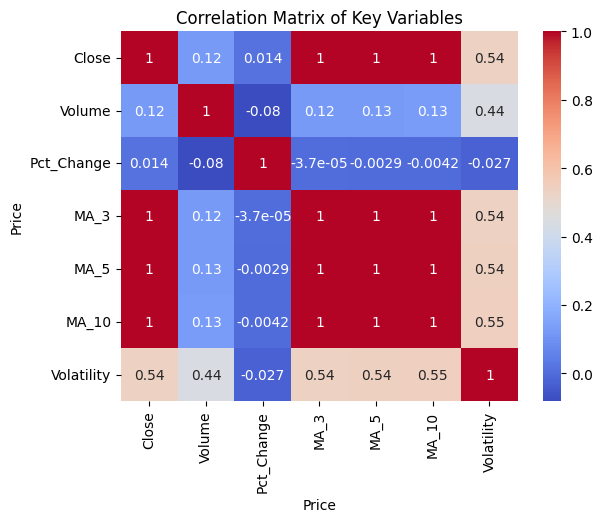

In [22]:
#Add Moving Average Features - RS
data['MA_3'] = data['Close'].rolling(window=3).mean()
data['MA_5'] = data['Close'].rolling(window=5).mean()
data['MA_10'] = data['Close'].rolling(window=10).mean()

# Drop rows with NaN values created by rolling windows
data.dropna(inplace=True)

# Correlation Matrix
corr_matrix = data[['Close','Volume','Pct_Change','MA_3','MA_5','MA_10','Volatility']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Key Variables')
plt.show()

## Visualizations

### Time-Series of Closing Prices

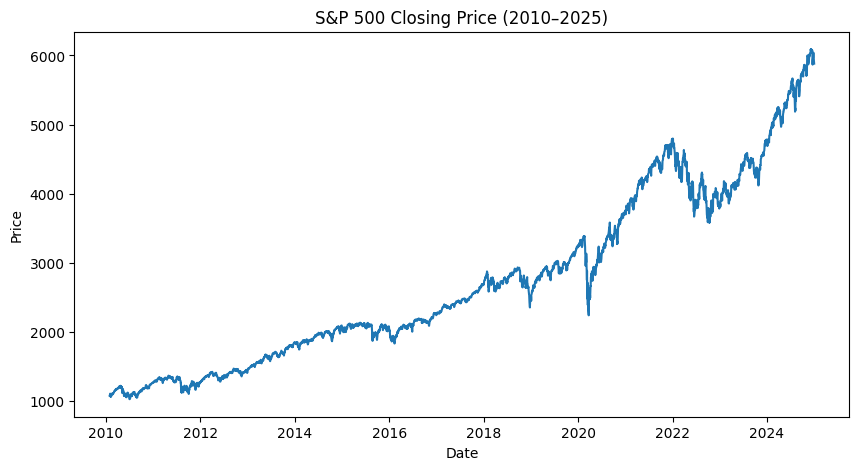

In [25]:
#Creating a plot to show a time series line chart to visualize market changes over time - RS

plt.figure(figsize=(10,5))
plt.plot(data['Date'], data['Close'])
plt.title('S&P 500 Closing Price (2010–2025)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

### Histogram of Daily % Change

Most daily returns cluster tightly around zero, which isn’t surprising for a broad market index like the S&P 500. What stands out is the handful of days with unusually large swings. These outliers remind us that the market can behave very differently during periods of stress, and any model we build needs to handle those rare but important events.

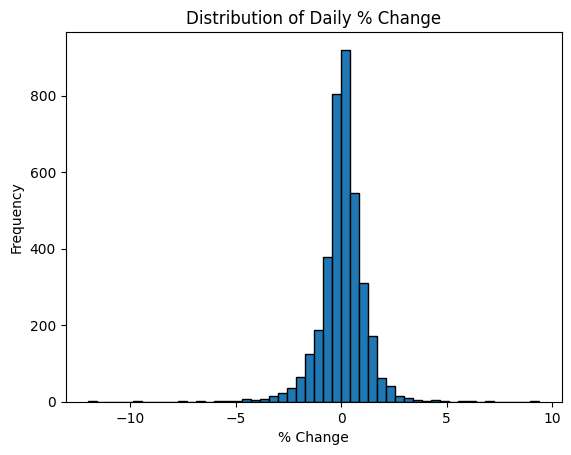

In [28]:
#RS
plt.hist(data['Pct_Change'], bins=50, edgecolor='black')
plt.title('Distribution of Daily % Change')
plt.xlabel('% Change')
plt.ylabel('Frequency')
plt.show()

### Boxplot of Volume by Market Direction

Trading volume tends to be a bit higher on days when the market drops. This pattern often shows up during periods when investors are reacting more emotionally or when institutions are making larger moves. It suggests that volume might help signal when the market is transitioning into a more “active” or uncertain state.

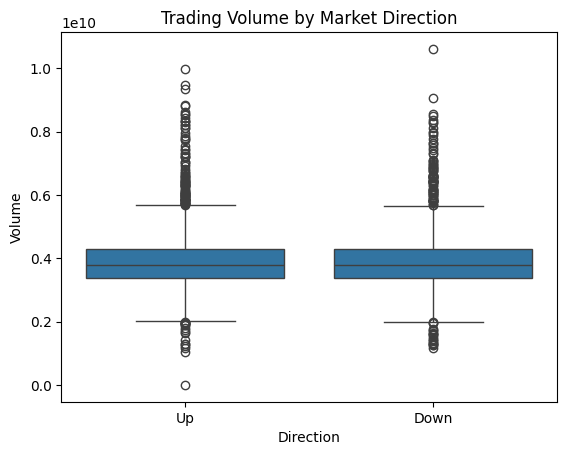

In [31]:
# Create Market Direction Column - RS
data['Direction'] = np.where(data['Close'].shift(-1) > data['Close'], 'Up', 'Down')

# Boxplot
sns.boxplot(x='Direction', y='Volume', data=data)
plt.title('Trading Volume by Market Direction')
plt.show()

### Moving Average Comparison

The 3-day moving average reacts quickly to changes in the market, while the 10-day average smooths out a lot of that short-term noise. By looking at them together, you can see when the market’s momentum is accelerating or slowing down. Even without explicit crossover markers, the distance between the lines gives a sense of how stable or volatile the recent trend has been, which helps explain short-term market behavior.

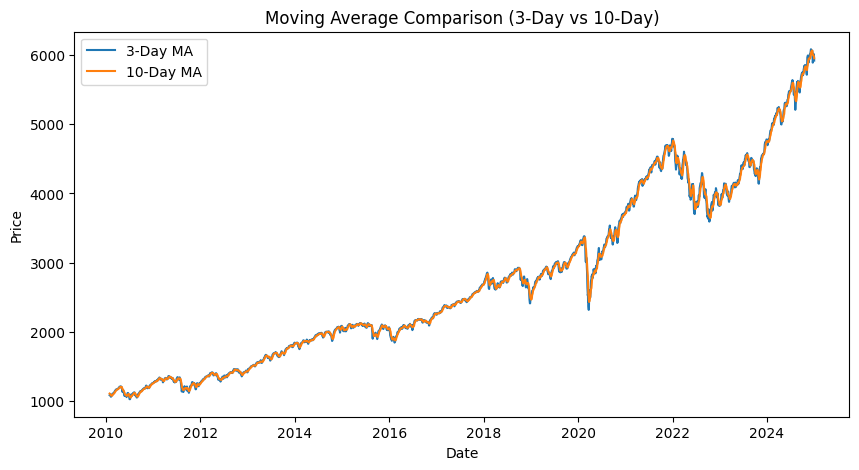

In [34]:
#RS
plt.figure(figsize=(10,5))
plt.plot(data['Date'], data['MA_3'], label='3-Day MA')
plt.plot(data['Date'], data['MA_10'], label='10-Day MA')
plt.legend()
plt.title('Moving Average Comparison (3-Day vs 10-Day)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

### Correlation Heatmap for Collinearity

The heatmap highlights strong relationships among the moving-average features (MA_3, MA_5, MA_10), which is expected since they’re all based on overlapping windows of the same price data. Percent change and volatility show weaker correlations with the moving averages, meaning they capture different aspects of market movement. This mix of highly related and more independent features helps clarify which variables may provide genuinely new information to a predictive model and which ones mainly overlap.

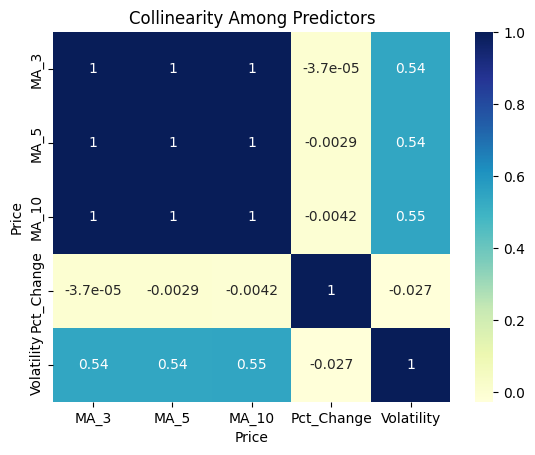

In [37]:
#RS
sns.heatmap(data[['MA_3','MA_5','MA_10','Pct_Change','Volatility']].corr(), annot=True, cmap='YlGnBu')
plt.title('Collinearity Among Predictors')
plt.show()

**Review Notes:** For the future of this project and any project, we need to be careful about data that is multindex
to prevent inaccurate data reads. I think for future projects, we may want to think about naming the data rather than
keeping it as 'data'- AA.

**Review Notes:** One of the main takeaways from this project was realizing how important it is to double-check how the data is structured when pulling it from an API. Early on, the multi-indexed columns caused some confusion during analysis and visualizations, which could have been avoided if we caught it sooner. For future parts of this project, using clearer variable names and checking the data setup earlier on would make the code easier to follow, help reduce mistakes, and improve team collaboration. - RS.

**Review Notes:** We were able to clearly identify return volatility and class imbalances. We'll need these for feature engineering later on - CG

***Discussion & Next Steps***

The exploratory data analysis provides several insights to our research question: Can simple machine-learning models identify short term patterns in S&P 500 pricing and volume to predict next-day market direction beyond random chance? Looking at S&P 500 Closing Price (Figure 1), it seems to show long term, steady growth from 2010-2025 marked by volatility, which is especially significant during major market events (ex. Covid-19 Crash). This supports our idea that the market isn't always as efficient in the short term and short term dynamics may reveal some predictability.

The distribution of percentage change in Figure 2 is pretty tightly centered around zero, which aligns with the Effficent Market Hypothesis' idea that day to day changes can mostly be attributed to noise. However, the data shows both left and right tails that are quite significant. It shows that volatility can be helpful in capturing short-term patterns. The summary statistics (table 1) show a very small daily return but the spread is wide (due to volatility). This shows that features that are volitility-based or other engineered features might become significant when looking at short term patterns.

The Correlation heatmap was quite significant because it revealed that the moving averages all move almost exactly the same way as eachother and as the closing price. This means there is some redundant information, and using all of them would be a detriment to our model. In contrast, volatility shows (weak) negative correlation with percent change, suggesting a different behavior. The Boxplots (Figure 3), look almost identical on the "up" and "Down" days, suggesting low predicitve value alone. Overall, the engineered features such as volatility and percent change are the most promising for simple classification models.

Overall, the exploratory data analysis supports our hypothesis that short-term patterns exist, even if minute. It shows with the right selection of features could help simple machine learning models like logistic regression and random forest predic the next day direction better than random guessing.



***Data Cleaning & Pre-processing Plan***

Based on our findings the next steps will focus on noise redundancy reduction so that it is most useful for our models. The moving average show high collinearity so we won't use all of these at the same time. Instead, we will chose one and further explore the creation of new features. We will also remove the raw price columns since our percent change already shows price movement.

To finish up the cleaning process, missing values from rolling calculations will be removed and a binary "Direction" column will be created so that it can be used for modeling. The continuous features such as percent change, volatility, and volume will be standardized so that they are on the same scale, which is especially important for logistic regression. Lastly limits will be applied to extreme outliers.

After the prepprocessing, we will do a 80/20 training split on the data and set up a validation system that avoids p-hacking, as outlined in the proposal. From there we will train the logistic regression and rain forest models and evaluate for accuracy, precision, recall, and F1-score. This will then be compared against a baseline and random guesing to see if our model can detect any short-term patterns. This will help us test our prediction that our models will acheive a predictive accuracy in the range 55-60% and reveal short-term patterns.

***Appendix A: Data Dictionary*** 

| **Variable Name** | **Type** | **Description** | **Source** |
|-------------------|----------|-----------------|------------|
| **Date** | Date | Trading Day | yfinance |
| **Open** | Float | Opening Price | yfinance |
| **High** | Float | Highest Price Reached | yfinance |
| **Low** | Float | Lowest Price Reached | yfinance |
| **Close** | Float | Closing Price | yfinance |
| **Volume** | Integer | Total number of Shares Traded | yfinance |
| **Pct_Change** | Float | Daily Percent Change in Closing Price Relative to the Previous Day. Calculated using `.pct_change()` | Engineered |
| **MA_3** | Float | 3-day Moving Average (closing prices) | Engineered |
| **MA_5** | Float | 5-day Moving Average (closing prices) | Engineered |
| **MA_10** | Float | 10-day Moving Average (closing prices) | Engineered |
| **Volatility_10** | Float | 10-day Rolling STD | Engineered |
| **Direction** | Up/Down | Target Variable Indicating Next Day's Close is Higher or Lower than Today | Engineered |
| **Price_to_Volume** | Float | Ratio of Daily Percent Price Change to Volume Change | Engineered |


This notebook was run end-to-end on my local machine without errors - AA

This notebook was run end-to-end on my local machine without errors - RS

This notebook was run end-to-end on my local machine without errors - CG